*I am sending you a copy of Student's Tables as you are the only man that's ever likely to use them!*
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/William_Sealy_Gosset.jpg/360px-William_Sealy_Gosset.jpg)



Here we compare using several techniques for comparing two samples of data:
* [Data Plotting](#Data-Viewing)
* [Analytic solutions](#Analytic-solutions) 
  * [Welch's approximate t](#Welch's-approximate-t) (tests equivalence of means, assumes data is normal, but different variances)
    * [hypothesis test](#Welch's-hypothesis-test)
    * [parameter likelihood](#Welch's-parameter-likelihood)
  * [rank sum](#rank-sum) (tests equivalence of medians, assumes groups have same shape and dispersion)
    * [hypothesis test](#Mann-Whitney-hypothesis-test)
    * [parameter likelihood](#Mann-Whitney-parameter-likelihood)

* Bayesian Estimation
  * MCMC
  * * simple
  * * with pymc

## Data Viewing

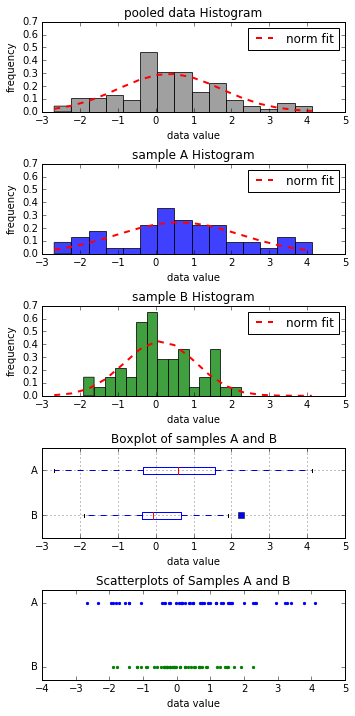

In [49]:
# VIEW DATA
#  generate two groups of data and display
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(7)
A = np.random.normal(loc=0.75, scale=1.5, size=50)
B = np.random.normal(loc=0.0, scale=1.0, size=50)
C = np.concatenate((A,B))

(mu_A, sigma_A) = stats.norm.fit(A)
(mu_B, sigma_B) = stats.norm.fit(B)
(mu_C, sigma_C) = stats.norm.fit(C)

#-----------------
plt.figure(figsize=(5,10))

#---------------------
# Combined = groups A and B
ax1 = plt.subplot(511)

#histogram
n_C, bins_C, patches_C = plt.hist(C, bins=15, normed=1, facecolor='gray', alpha=0.75)

# add a 'best fit' norm line
y = stats.norm.pdf(bins_C, mu_C, sigma_C)
l = plt.plot(bins_C, y, 'r--', linewidth=2, label='norm fit')
plt.title('pooled data Histogram')
plt.ylabel('frequency')
plt.xlabel('data value')
plt.legend()

# add a kde line
'''
gkde_C = gaussian_kde(C)
plt.plot(bins_C,gkde_C(bins_C), 'b--', linewidth=2, label='Combined KDE')
'''
#---------------------
#sample A
plt.subplot(512, sharex=ax1, sharey=ax1)
# histogram
n, bins, patches = plt.hist(A, bins=15, normed=1, facecolor='blue', alpha=0.75)

# add a 'best fit' line
y = stats.norm.pdf(bins_C, mu_A, sigma_A)
l = plt.plot(bins_C, y, 'r--', linewidth=2, label='norm fit')

plt.title('sample A Histogram')
plt.ylabel('frequency')
plt.xlabel('data value')
plt.legend()
#---------------------
#sample B
plt.subplot(513, sharex=ax1, sharey=ax1)
# histogram
n, bins, patches = plt.hist(B, bins=15, normed=1, facecolor='green', alpha=0.75)

# 'best fit' line
y = stats.norm.pdf(bins_C, mu_B, sigma_B)
l = plt.plot(bins_C, y, 'r--', linewidth=2, label='norm fit')

plt.title('sample B Histogram')
plt.ylabel('frequency')
plt.xlabel('data value')
plt.legend()

#---------------------
# boxplots
plt.subplot(5,1,4)
plt.boxplot([B,A], 0, 'rs', 0)
plt.yticks([1, 2], ['B', 'A'])
plt.title('Boxplot of samples A and B')
plt.xlabel('data value')
plt.grid(b=True)

#---------------------
#scatter
plt.subplot(5,1,5)
plt.scatter(A,np.ones_like(A), marker='.', color='b')

plt.scatter(B, np.zeros_like(B), marker='.', color='g')
plt.yticks([0, 1], ['B', 'A'])
plt.title('Scatterplots of Samples A and B')
plt.xlabel('data value')

plt.tight_layout(pad=1, w_pad=1, h_pad=1.0)
plt.show()

## Analytic solutions

## Welch's approximate t
aka: [Behrens–Fisher problem](https://en.wikipedia.org/wiki/Behrens%E2%80%93Fisher_problem), Welch's t-test

Given two samples of data, A and B, and assuming:

**Assumptions:** 
* sample A and sample B came from normal distributions $\mathcal{N}(\mu_A,\sigma_A)$,
and $\mathcal{N}(\mu_B,\sigma_B)$
* sample A and sample B population distributions might not have same variance

**Find:** an analytic probability distribution that $\mu_A = \mu_B$

In [50]:
# run a Welch's t-test 
#  assumes samples are normally distrubuted 
#  and that the variances in each group may be different

t,t_p_value = stats.ttest_ind(A, B, axis=0, equal_var=False)
print('t-test p_value: ',t_p_value)




('t-test p_value: ', 0.070240300645363782)
('mw-test p_value: ', 0.026573998541097359)


## parameter likelihood
### analytical calculation

### Analyzing the confidence of our estimates of the sample means.

MLE gives us the most likely sample mean. We can also calculate the expected variance of the MLE mean estimate. In other words, we can express the pdf of the sample mean. Given sample A, with a sample mean of $\mu_A$, and a sample st. dev. of $\sigma_A$, the distribution of the sample mean's difference from the population mean $\sigma_{\mu_A}$ is given by the t-distribution:


>$P((\bar{X_A}-\mu_{A_{pop}})*\frac{\sqrt(N)}{S_A}) = \text{t-dist}$

Also, the likelihood plot of $(\mu_1 - \mu_2)$, is given by:

>$\mu_{\mu_1 - \mu_2} = \mu_1 - \mu_2$

>$\sigma_{\mu_1 - \mu_2} = \sqrt{\sigma_{\mu_1}^2 + \sigma_{\mu_2}^2}$


This can be verified by doing a convolution of two Gaussian pdfs.

This analysis dependent upon the assumption that the samples are coming from a population with a normal distribution.

This type of analysis becomes analytically very difficult when we have non-standard distributions (perhaps, for example, a noncentral T-distribution). 



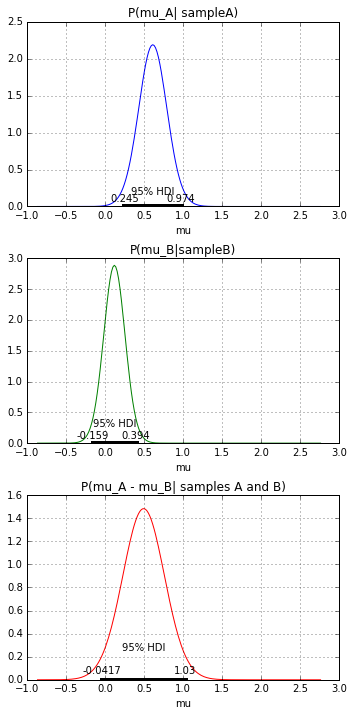

In [85]:
# using analytical formulas for Gaussian assumptions, plot pdf of parameters

# we only consider mus in the middle histogram range
mus = np.linspace(bins_C[len(bins_C)/4], bins_C[-len(bins_C)/4], 200)
x_range = bins_C[-len(bins_C)/4] - bins_C[len(bins_C)/4]

sigma_mus_A = np.sqrt(A.var(ddof=1))/len(A)
p_mus_A = stats.t.pdf(mus, loc=A.mean(), scale=np.sqrt(sigma_mus_A), df = len(A)-1)
plt.figure(figsize=(5,10))
plt.subplot(311)
plt.plot(mus, p_mus_A, color='b')
plt.title('P(mu_A| sampleA)')
plt.xlabel('mu')
plt.grid(1)

# add the HDI
HDI_low = stats.t.ppf(.025, loc=A.mean(), scale=np.sqrt(sigma_mus_A), df=len(A)-1)
HDI_high = stats.t.ppf(.975, loc=A.mean(), scale=np.sqrt(sigma_mus_A), df=len(A)-1)
HDI = [HDI_low, HDI_high]
plt.plot( HDI, [0,0],lw=5.0, color='k')

plt.text( HDI[0], 0.04, '%.3g'%HDI[0],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( HDI[1], 0.04, '%.3g'%HDI[1],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( sum(HDI)/2, 0.14, '95% HDI',
         horizontalalignment='center',
         verticalalignment='bottom',
         )
#-------

plt.subplot(312)
sigma_mus_B = np.sqrt(B.var(ddof=1))/len(B)
p_mus_B = stats.t.pdf(mus, loc=B.mean(), scale=np.sqrt(sigma_mus_B), df=len(B)-1)
plt.plot(mus, p_mus_B, color='g')
plt.title('P(mu_B|sampleB)')
plt.xlabel('mu')
plt.grid(1)

# add the HDI
HDI_low = stats.t.ppf(.025, loc=B.mean(), scale=np.sqrt(sigma_mus_B),df=len(B)-1)
HDI_high = stats.t.ppf(.975, loc=B.mean(), scale=np.sqrt(sigma_mus_B),df=len(B)-1)
HDI = [HDI_low, HDI_high]
plt.plot( HDI, [0,0],lw=5.0, color='k')

plt.text( HDI[0], 0.04, '%.3g'%HDI[0],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( HDI[1], 0.04, '%.3g'%HDI[1],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( sum(HDI)/2, 0.24, '95% HDI',
         horizontalalignment='center',
         verticalalignment='bottom',
         )

#---------------
plt.subplot(313)
mu_diff = A.mean()-B.mean()

df_diff_num = ( A.var(ddof=1)/len(A) + B.var(ddof=1)/len(B) )**2
df_diff_den = ( (A.var(ddof=1)/len(A))**2/(len(A)-1) + 
                (B.var(ddof=1)/len(B))**2/(len(B)-1) )
df_diff = np.floor(df_diff_num/df_diff_den)

sigma_diff = A.var(ddof=1)/len(A) + B.var(ddof=1)/len(B)

p_mus_diff = stats.t.pdf(mus, loc=(mu_diff), scale=np.sqrt(sigma_diff), df=df_diff)
plt.plot(mus, p_mus_diff, color='r')
plt.title('P(mu_A - mu_B| samples A and B)')
plt.xlabel('mu')
plt.grid(1)

# add the HDI
HDI_low = stats.t.ppf(.025, loc=(mu_diff), scale=np.sqrt(sigma_diff), df=df_diff)
HDI_high = stats.t.ppf(.975, loc=(mu_diff), scale=np.sqrt(sigma_diff), df=df_diff)
HDI = [HDI_low, HDI_high]
plt.plot( HDI, [0,0],lw=5.0, color='k')

plt.text( HDI[0], 0.04, '%.3g'%HDI[0],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( HDI[1], 0.04, '%.3g'%HDI[1],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( sum(HDI)/2, 0.24, '95% HDI',
         horizontalalignment='center',
         verticalalignment='bottom',
         )

plt.tight_layout(pad=1, w_pad=1, h_pad=1.0)
plt.show()


# Mann Whitney test

In [ ]:
mw,mw_p_value = stats.mannwhitneyu(A,B)
print('mw-test p_value: ',mw_p_value)

# pymc for MCMC estimation

In this example

In [52]:
# lets use MCMC to find:
#   P(mu_A|a), P(mu_B|B), P(mu_A-mu_B|A,B)
# following code example from:
# https://github.com/HHammond

import pymc as pm  
import numpy as np  

# Generate some random normal data
group1 = A  
group2 = B

# Generate Pooled Data
pooled = np.concatenate((group1,group2))  

# Setup our priors
mu1 = pm.Normal("mu_1",mu=pooled.mean(), tau=1.0/pooled.var()/1000.0)  
mu2 = pm.Normal("mu_2",mu=pooled.mean(), tau=1.0/pooled.var()/1000.0)

sig1 = pm.Uniform("sigma_1",lower=pooled.var()/1000.0,upper=pooled.var()*1000)  
sig2 = pm.Uniform("sigma_2",lower=pooled.var()/1000.0,upper=pooled.var()*1000)

v = pm.Exponential("nu",beta=1.0/29)  

# Include our observed data into the model
t1 = pm.NoncentralT("t_1",mu=mu1, lam=1.0/sig1, nu=v, value=group1[:], observed=True)  
t2 = pm.NoncentralT("t_2",mu=mu2, lam=1.0/sig2, nu=v, value=group2[:], observed=True)

# Push our priors into a model
model = pm.Model( [t1, mu1, sig1, t2, mu2, sig2, v] )

# Generate our MCMC object
mcmc = pm.MCMC(model)  

# Run MCMC sampler
mcmc.sample(80000,10000,2)  



 [-----------------100%-----------------] 80000 of 80000 complete in 12.4 sec

Plotting mu_2
Plotting sigma_2
Plotting mu_1
Plotting nu
Plotting sigma_1


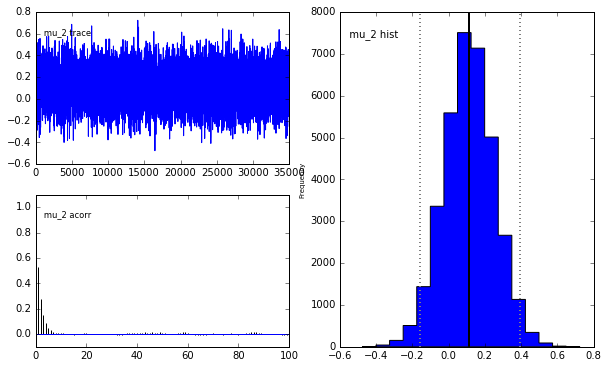

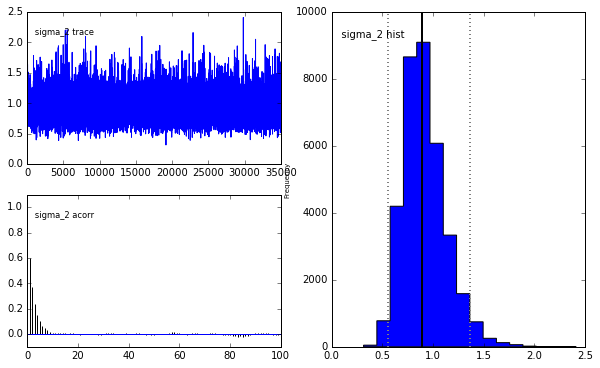

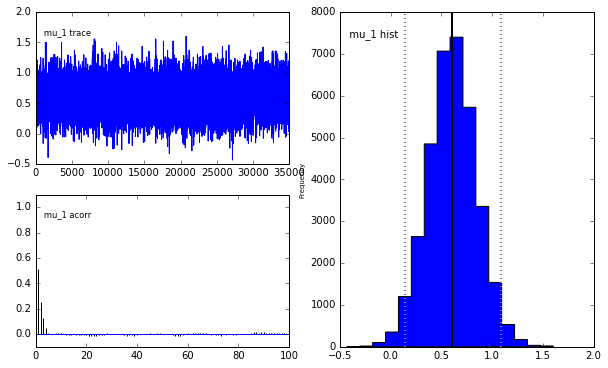

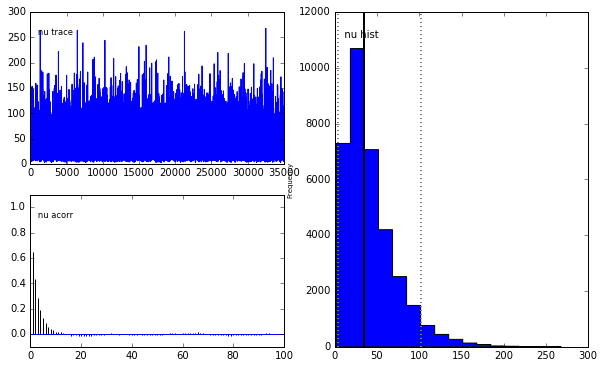

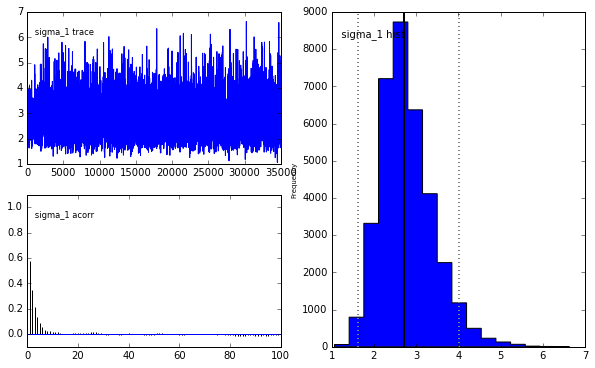

In [53]:
#check for convergence
pm.Matplot.plot(mcmc)

('mu_1', 0.60649553115265098)
('mu_2', 0.11309504230677199)


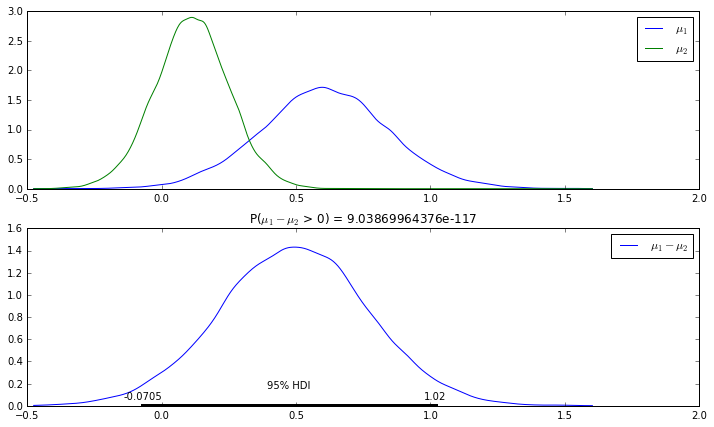

In [54]:
#plot the sampled mus and mu_difference

mus1 = mcmc.trace('mu_1')[:]  
mus2 = mcmc.trace('mu_2')[:]  
sigmas1 = mcmc.trace('sigma_1')[:]  
sigmas2 = mcmc.trace('sigma_2')[:]  
nus = mcmc.trace('nu')[:]  

diff_mus = mus1-mus2  
diff_sigmas = sigmas1-sigmas2  
normality = np.log(nus)  
effect_size = (mus1-mus2)/np.sqrt((sigmas1**2+sigmas2**2)/2.)  

print("mu_1", mus1.mean()) 
print("mu_2", mus2.mean())  

from scipy.stats import gaussian_kde  
plt.figure(figsize=(10,6))

# prepare plotting area to fit both graphs
minx = min(min(mus1),min(mus2))  
maxx = max(max(mus1),max(mus2))  
# x values to plot on
xs = np.linspace(minx,maxx,1000)

# generate density estimates
gkde1 = gaussian_kde(mus1)  
gkde2 = gaussian_kde(mus2)

# draw plots
plt.subplot(211)
plt.plot(xs,gkde1(xs),label='$\mu_1$')  
plt.plot(xs,gkde2(xs),label='$\mu_2$')  
plt.legend()  

plt.subplot(212)
H0_p = (diff_mus > 0).mean()  
H1_p = (diff_mus < 0).mean()  
gkde_diff = gaussian_kde(diff_mus)
plt.plot(xs,gkde_diff(xs),label='$\mu_1 - \mu_2$') 
title = 'P($\mu_1 - \mu_2$ > 0) = ' + str(p)
HDI = pm.utils.hpd(diff_mus, .05)
plt.plot( HDI, [0,0],lw=5.0, color='k')
plt.text( HDI[0], 0.04, '%.3g'%HDI[0],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( HDI[1], 0.04, '%.3g'%HDI[1],
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.text( sum(HDI)/2, 0.14, '95% HDI',
         horizontalalignment='center',
         verticalalignment='bottom',
         )
plt.title(title)
plt.legend()  

plt.tight_layout(pad=1, w_pad=1, h_pad=1.0)
plt.show()  

In [55]:
#we can use the sampled distributions to test the null hypothesis
p = (diff_mus > 0).mean()  
print('percent of samples where (mu1 > mu2) = ', p)

('percent of samples where (mu1 > mu2) = ', 0.96122857142857143)


In [56]:
#An alternative way to test the equivalence of mus is to see if 
#zero is within the 95% highest density interval

print(pm.utils.hpd(diff_mus, .1))

[ 0.02756248  0.93772504]


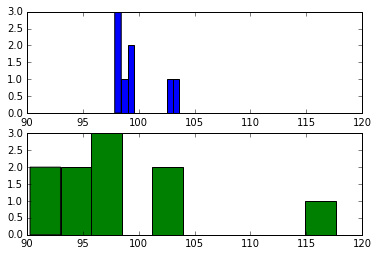

0.000210526315789


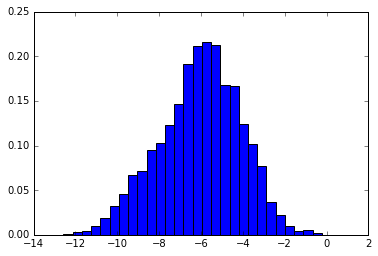

In [58]:
# BASIC ALL

# copied largely from: 
# http://stats.stackexchange.com/questions/130389/bayesian-equivalent-of-two-sample-t-test/135725

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def dnorm(x, mu, sig):
    return 1/(sig * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sig**2))

#dnorm = stats.norm.pdf

def dexp(x, l):
    return l * np.exp(- l*x)

def like(parameters):
    """ P(D|param) """
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(sample1, mu1, sig1).prod() * dnorm(sample2, mu2, sig2).prod()

def prior(parameters):
    """ P(param) """
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(mu1, pooled.mean(), 1000*pooled.std()) * \
           dnorm(mu2, pooled.mean(), 1000*pooled.std()) * \
           dexp(sig1, 0.1) * dexp(sig2, 0.1)

def posterior(parameters):
    #return like(parameters) * prior(parameters)
    return like(parameters)


#create samples
sample1 = np.random.normal(100, 3, 8)
sample2 = np.random.normal(100, 7, 10)

pooled= np.append(sample1, sample2)

plt.figure(0)
ax1 = plt.subplot(211)
plt.hist(sample1, facecolor='blue')
#plt.hold(True)
plt.subplot(212, sharex=ax1)
plt.hist(sample2, facecolor='green')
plt.show()

mu1 = 100 
sig1 = 10
mu2 = 100
sig2 = 10
parameters = np.array([mu1, sig1, mu2, sig2])

niter = 10000

results = np.zeros([niter, 4])
results[1,:] = parameters

for iteration in np.arange(2,niter):
    candidate = parameters + np.random.normal(0,0.5,4)
    ratio = posterior(candidate)/posterior(parameters)
    if np.random.uniform() < ratio: #0-1, 
        parameters = candidate
    results[iteration,:] = parameters

#burn-in
results = results[499:niter-1,:]

mu1 = results[:,1]
mu2 = results[:,3]

d = (mu1 - mu2)
p_value = np.mean(d > 0)

print(p_value)
plt.figure()
plt.hist(d,bins=30, normed = 1)
plt.show()

In [59]:
a = np.array([1,2,3])
print(a.prod())

6
